In [1]:
import sys

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from sklearn import metrics

sys.path.append('../src')
import columnar as col

%load_ext autoreload
%autoreload 2

# Categorical Embeddings
Alternative to General

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from sklearn.model_selection import train_test_split

df = col.loaders.petfinder._load('../')
feature_selection = col.FeatureSelection(**col.loaders.petfinder._select_features(df))

# split data
df_train, df_test = train_test_split(df, test_size=.2)

X_train, y_train = feature_selection.select_features(df_train)
ds_train = col.embeddings.data.df_to_dataset(X_train, y_train, batch_size=32)

X_test, y_test = feature_selection.select_features(df_test)
ds_test = col.embeddings.data.df_to_dataset(X_test, y_test, batch_size=32, shuffle=False)

# setup scorer
scorer = col.Scorer(
    acc=lambda ytrue, ypreds: metrics.accuracy_score(ytrue, ypreds > .5),
    f1=lambda ytrue, ypreds: metrics.f1_score(ytrue, ypreds > .5),
    auc=metrics.roc_auc_score,
)

Metal device set to: Apple M1 Pro


2022-02-06 21:22:25.265479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-06 21:22:25.265603: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
df.target.mean()

0.7200693657039952

In [5]:
{col: df[col].nunique() for col in df.columns}

{'type': 2,
 'age': 106,
 'breed1': 176,
 'breed2': 135,
 'gender': 3,
 'color1': 7,
 'color2': 7,
 'color3': 6,
 'maturitysize': 4,
 'furlength': 3,
 'vaccinated': 3,
 'dewormed': 3,
 'sterilized': 3,
 'health': 3,
 'quantity': 19,
 'fee': 74,
 'state': 14,
 'rescuerid': 5595,
 'videoamt': 9,
 'photoamt': 31,
 'has_name': 2,
 'target': 2}

In [8]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

pipe = col.CategoricalPipeline(features=feature_selection,
                              transformer=col.MeanTargetEncoder(feature_selection),
                              model=RandomForestClassifier(max_depth=5, n_estimators=100))

pipe.fit(df_train)
f1_score(df_test.target, (pipe.predict(df_test) > .5))

0.8490088570223535

In [11]:
report = pd.read_csv('../runs/petfinder.csv', sep=';')
report['score'] = (report.auc - report['auc-std']) * (report.f1 - report['f1-std']) / (report.auc + report.f1)
report.sort_values('score', ascending=False)

,feature_selection,transformer,scaler,classifier,acc,f1,auc,acc-std,f1-std,auc-std,score
25,"FeatureSelection(categoricals=['type', 'breed1...",TFEmbeddingWrapper_Max50Strategy,MaxAbsScaler(),LGBMClassifier(),0.791769,0.856381,0.825467,0.004239,0.003831,0.011024,0.412851
15,"FeatureSelection(categoricals=['type', 'breed1...",TFEmbeddingWrapper_SingleStrategy,MaxAbsScaler(),LGBMClassifier(),0.778563,0.847397,0.830678,0.005054,0.008439,0.006720,0.411940
5,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy_OneHotEncoder(handle_unknown...,MaxAbsScaler(),LogisticRegression(max_iter=500),0.778897,0.858412,0.809063,0.002123,0.002247,0.008694,0.410949
18,"FeatureSelection(categoricals=['type', 'breed1...",TFEmbeddingWrapper_Max2Strategy,MaxAbsScaler(),LogisticRegression(max_iter=500),0.776095,0.848886,0.813520,0.004885,0.003152,0.007788,0.409909
20,"FeatureSelection(categoricals=['type', 'breed1...",TFEmbeddingWrapper_Max2Strategy,MaxAbsScaler(),LGBMClassifier(),0.778829,0.844330,0.833621,0.012992,0.013648,0.006843,0.409303
3,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),LGBMClassifier(),0.783632,0.859122,0.809476,0.006733,0.005400,0.010421,0.408829
13,"FeatureSelection(categoricals=['type', 'breed1...",TFEmbeddingWrapper_SingleStrategy,MaxAbsScaler(),LogisticRegression(max_iter=500),0.772827,0.849207,0.805647,0.004041,0.003867,0.007078,0.407929
0,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),RandomForestClassifier(max_depth=5),0.762422,0.849789,0.812806,0.008118,0.006002,0.009579,0.407647
21,"FeatureSelection(categoricals=['type', 'breed1...",TFEmbeddingWrapper_Max2Strategy,MaxAbsScaler(),DNN,0.772693,0.840014,0.824273,0.011027,0.010218,0.008846,0.406564
1,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),LogisticRegression(max_iter=500),0.762889,0.848827,0.803403,0.008298,0.006527,0.009249,0.404856


In [73]:
metrics = ['acc', 'f1', 'auc']
report[metrics].min().min()

0.6442672011335976

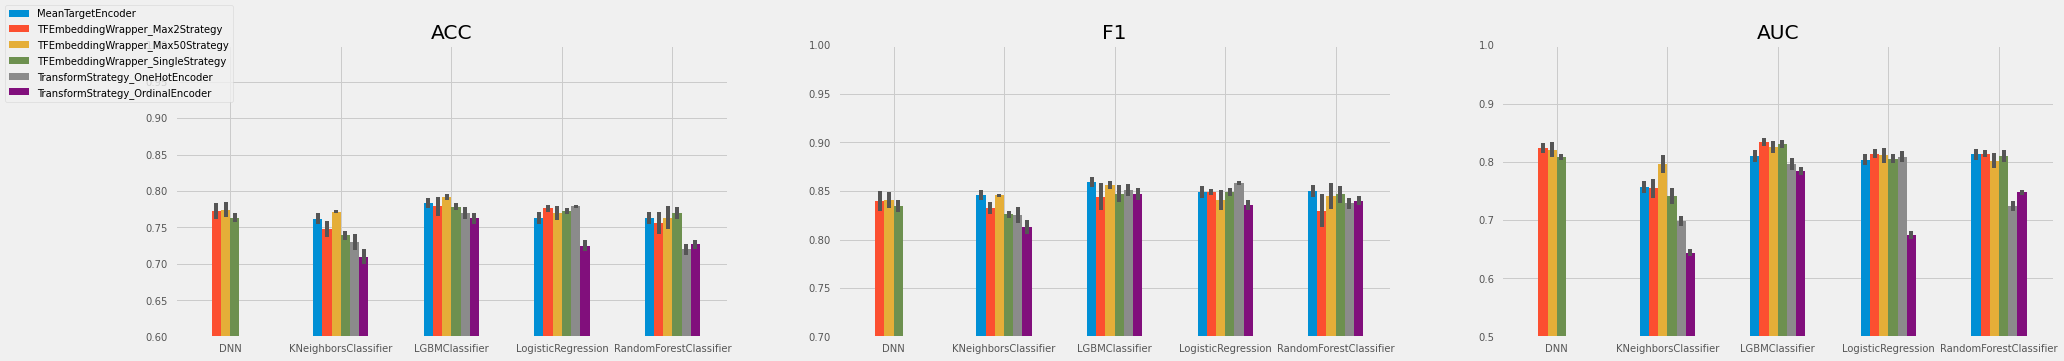

In [68]:
fig = col.plot_model_encoder_pairs(reporter, figpath='../figures/petfinder.png')

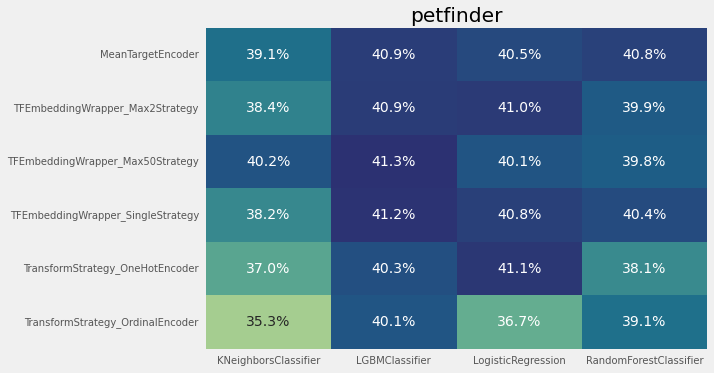

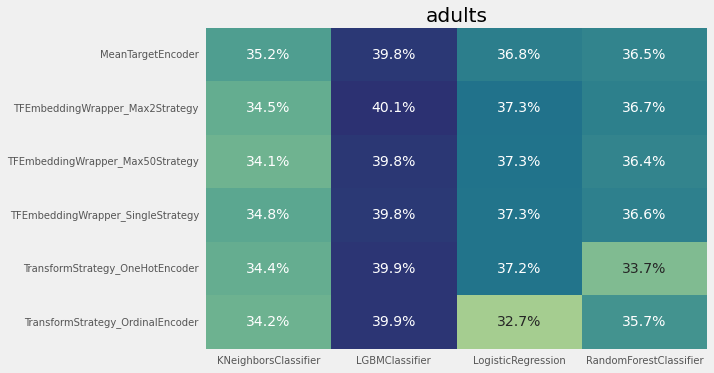

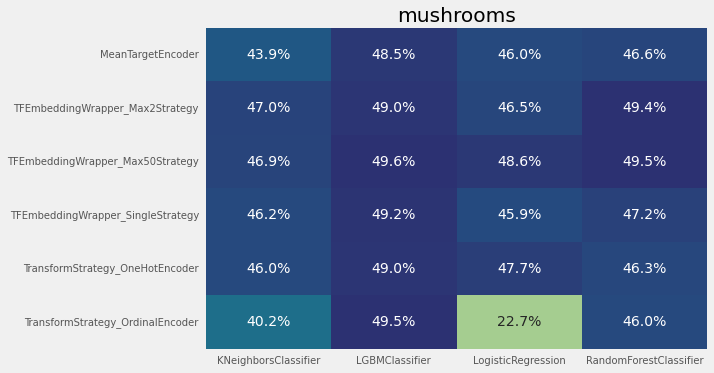

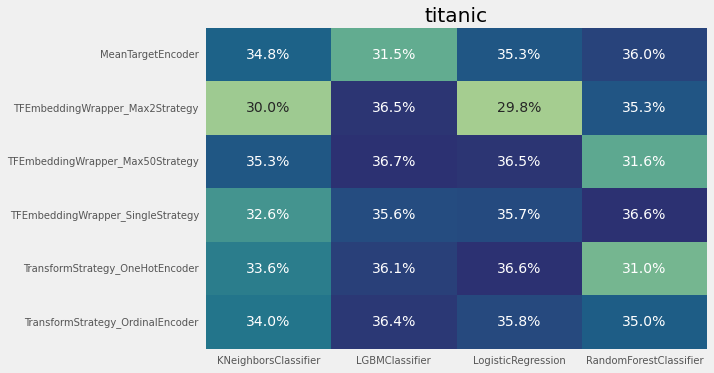

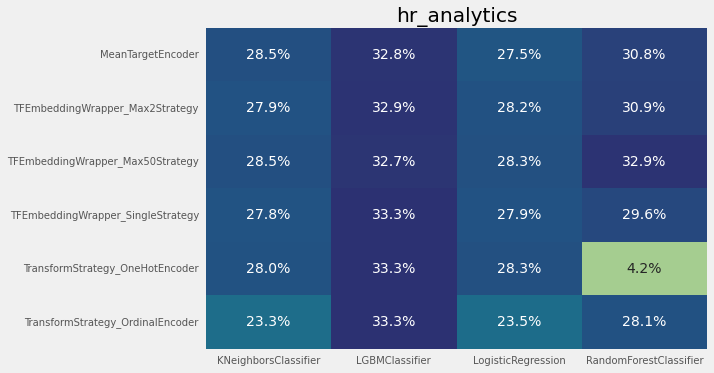

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns


def get_summary(df, metric):
    summary = pd.pivot(df, columns='classifier', index='transformer', values=metric)
    summary = col.plot._clean_index_column_names(summary)
    return summary


filepath = '../runs/adults.csv'

tasks = ['petfinder', 'adults', 'mushrooms', 'titanic', 'hr_analytics']

for task in tasks:
    filepath = f'../runs/{task}.csv'
    report = col.Report.from_csv(filepath).report

    report['score'] = (report.f1 - report['f1-std']) * (report.auc - report['auc-std']) / (report.f1 + report.auc)

    summary = get_summary(report, 'score').drop(columns='DNN')

    sns.heatmap(summary, cmap='crest', annot=True, fmt='.1%', cbar=False)#, center=.411)
    plt.title('score ~ f1 * auc / (f1 + auc)');
    plt.title(task);
    plt.show()

# testing classifier

In [9]:
# define encoding_strategy
transform_strategy = col.embeddings.models.BaseTransformStrategy(features=feature_selection, 
                                                                 emb_size_strategy='single')

# instantiate embeddings encoder
encoder = col.embeddings.models.TFCatEmbsEncoder(transform_strategy)
# instantiate classifier
model = col.embeddings.models.TFCatEmbsClassifier(encoder)

# build model based on training data (generate embeddings)
model.adapt(ds_train)

model.compile(optimizer='adam',
               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
               metrics=["accuracy"])

# fit on training data, validate on test
hist = model.fit(ds_train, epochs=3, validation_data=ds_test)


2022-02-05 21:26:47.684343: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-05 21:26:47.718298: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:26:48.136437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:26:48.534193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:26:48.949364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:26:49.381182: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:26:49.790149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

Epoch 1/3


2022-02-05 21:26:58.942048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.6161

2022-02-05 21:27:21.312415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 24s 60ms/step - loss: 0.6034 - accuracy: 0.6161 - val_loss: 0.5655 - val_accuracy: 0.7076
Epoch 2/3
375/375 [==============================] - 23s 60ms/step - loss: 0.5553 - accuracy: 0.7043 - val_loss: 0.5228 - val_accuracy: 0.7352
Epoch 3/3
375/375 [==============================] - 23s 60ms/step - loss: 0.4886 - accuracy: 0.7499 - val_loss: 0.4738 - val_accuracy: 0.7633


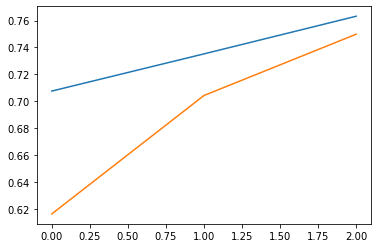

In [10]:
import matplotlib.pyplot as plt
plt.plot(hist.history.get('val_accuracy'))
plt.plot(hist.history.get('accuracy'))
plt.show()

# Testing Wrapper Transformer

In [11]:
transformer = col.embeddings.wrapper.TFEmbeddingWrapper(features=feature_selection, 
                                                        emb_size_strategy='single')
transformer.fit(X_train, y_train, epochs=3);

2022-02-05 21:28:49.390709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:28:49.788548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:28:50.181296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:28:50.584912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:28:50.977249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:28:51.370130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 21:28:51.758633: I tensorflow/core/grappler/optimizers/cust

Epoch 1/3


2022-02-05 21:29:00.285540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 25s 65ms/step - loss: 0.5961 - accuracy: 0.6125
Epoch 2/3
375/375 [==============================] - 24s 65ms/step - loss: 0.5423 - accuracy: 0.7164
Epoch 3/3
375/375 [==============================] - 24s 65ms/step - loss: 0.4701 - accuracy: 0.7696


2022-02-05 21:30:14.134096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [14]:
X_train_ = transformer.transform(X_train)
X_test_ = transformer.transform(X_test)

2022-02-05 19:45:41.296655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [15]:
from sklearn import metrics

scorer = col.Scorer(
        acc=lambda x, y: metrics.accuracy_score(x,y>.5),
        f1=lambda x, y: metrics.f1_score(x,y>.5),
        auc=metrics.roc_auc_score,
    )

scorer.score(y_test, y_test)

{'acc': 1.0, 'f1': 1.0, 'auc': 1.0}

# compare all classifiers on transformer's output

In [14]:
from collections import namedtuple
Args = namedtuple("Args", ["task"])

args = Args(task='petfinder')
args.task

'petfinder'

Comparing (model, encoder) pairs for the petfinder classification task
	loading dataset
	  5 cross-validations 
    	x 3 transformers
    	x 4 models 
    	combinations to train and test
evaluation completed
results summary saved in runs/petfinder.csv


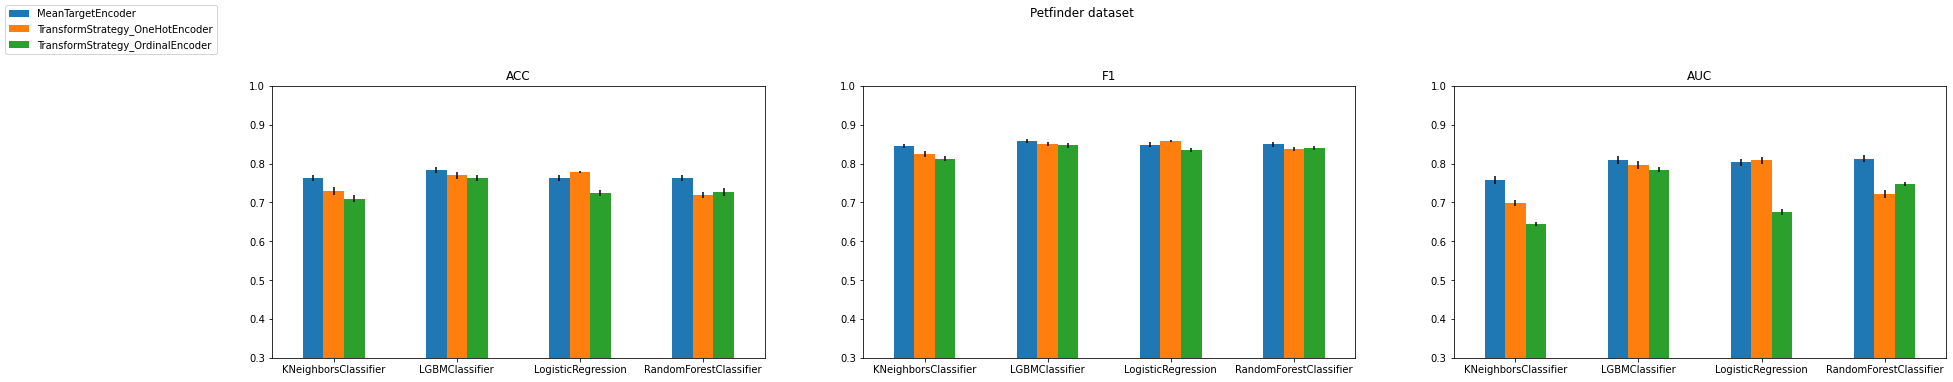

visualization saved in figures/petfinder.png


,model,transformer,acc,f1,auc
0,RandomForestClassifier(max_depth=5),"MeanTargetEncoder(target=target, alpha=5)",0.763023,0.850182,0.812883
1,LogisticRegression(max_iter=500),"MeanTargetEncoder(target=target, alpha=5)",0.762889,0.848827,0.803403
2,KNeighborsClassifier(n_neighbors=10),"MeanTargetEncoder(target=target, alpha=5)",0.762222,0.845596,0.757023
3,LGBMClassifier(),"MeanTargetEncoder(target=target, alpha=5)",0.783632,0.859122,0.809476
4,RandomForestClassifier(max_depth=5),TransformStrategy_OneHotEncoder(handle_unknown...,0.720070,0.837238,0.722639
5,LogisticRegression(max_iter=500),TransformStrategy_OneHotEncoder(handle_unknown...,0.778897,0.858412,0.809063
6,KNeighborsClassifier(n_neighbors=10),TransformStrategy_OneHotEncoder(handle_unknown...,0.729808,0.825313,0.698832
7,LGBMClassifier(),TransformStrategy_OneHotEncoder(handle_unknown...,0.770026,0.850893,0.796153
8,RandomForestClassifier(max_depth=5),TransformStrategy_OrdinalEncoder(handle_unknow...,0.726740,0.840129,0.747520
9,LogisticRegression(max_iter=500),TransformStrategy_OrdinalEncoder(handle_unknow...,0.725073,0.835967,0.674918


In [11]:
import os

from itertools import permutations

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.base import clone, TransformerMixin
from sklearn import metrics
from sklearn.preprocessing import MaxAbsScaler, OneHotEncoder, OrdinalEncoder

ROOT_PATH = '../'


def _get_key(transformer, model) -> str:
    return str(transformer) + ':' + str(model)

class Logger:
    """logs individual results from a CV"""
    def __init__(self):
        self.reports = {}
    def log_results(self, transformer, model, results) -> None:
        
        report_key = _get_key(transformer, model)
                
        if report_key not in self.reports:
            self.reports[report_key] = []
        
        self.reports[report_key].append(results)
        
    def get_report(transformer, model):
        report_key = _get_key(transformer, model)
        return pd.DataFrame(self.reports[report_key])
        
class BenchmarkRunner:
    def __init__(self, transformers: , classifiers, logger, scorer):
        self.models = models
        self.transformers = transformers
        self.logger = logger
        self.scorer = scorer
        
    def run(X_train, X_test, y_train, y_test):
        """run transformer / scaler / classifier pipeline for each 
        combination of transformer / classifier defined in the benchmark. 
        to increase efficiency, transformations are only done once, and 
        classifiers are fitted on the same transformed dataset."""
        for t in transformers:
            # initialize transformer
            transformer = clone(t)
            
            # fit on training data and transform
            transformer.fit(X_train, y_train)
            
            X_train_ = transformer.transform(X_train)
            X_test_ = transformer.transform(X_test)
            
            # rescale data
            scaler = MaxAbsScaler()
            X_train_ = scaler.fit_transform(X_train_)
            X_test_ = scaler.transform(X_test_)
            
            for m in models:
                model = clone(m)
                
                # fit on transformed features
                model.fit(X_train_, y_train)
                
                # get predictions from pipeline on test set
                preds = model.predict_proba(X_test_)[:,1]
                
                # log results
                logger.log_results(transformer, model, 
                                   results=scorer.score(y_test, preds))
                
                
            # add an extra evaluation with original DNN for TFEmbedding Wrappers
            if transformer.__class__ == col.embeddings.wrapper.TFEmbeddingWrapper:
                # get predictions
                preds = transformer.model.predict(col.embeddings.data.df_to_dataset(X_test))
                
                # log results
                logger.log_results(transformer, 'DNN', 
                                   results=scorer.score(y_test, preds))

def main(args):
    
    print(f"Comparing (model, encoder) pairs for the {args.task} classification task")
    print(f"\tloading dataset")
    # load data
    loader = col.DataLoader(root=ROOT_PATH, task=args.task)
    data = loader.load_data()
    
    # define scoring metrics of interest
    scorer = col.Scorer(
        acc=lambda x, y: metrics.accuracy_score(x,y>.5),
        f1=lambda x, y: metrics.f1_score(x,y>.5),
        auc=metrics.roc_auc_score,
    )

    # define cross validation strategy
    kf = KFold(n_splits=5)
    
    # define features to select
    feature_selection = col.FeatureSelection(**loader.get_selected_features(data))
    
    reporter = col.Report(scorer=scorer)
    reporter.set_columns_to_show(['model', 'transformer'] + list(scorer.scoring_fcts.keys()))

    models = [
        RandomForestClassifier(n_estimators=100, max_depth=5),
        LogisticRegression(max_iter=500),
        KNeighborsClassifier(n_neighbors=10),
        LGBMClassifier(),
    ]

    transformers = [
        col.MeanTargetEncoder(feature_selection),
        col.TransformStrategy(feature_selection, OneHotEncoder(handle_unknown='ignore')),
        col.TransformStrategy(feature_selection, OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
        # col.embeddings.wrapper.TFEmbeddingWrapper(features=feature_selection, emb_size_strategy='single')
    ]
    
    logger = Logger()

    print(f"""\t  5 cross-validations 
    \tx {len(transformers)} transformers
    \tx {len(models)} models 
    \tcombinations to train and test""")
    
    for train_idx, test_idx in kf.split(data):
        
        # split train and test data using the CV fold
        cv_train, cv_test = data.iloc[train_idx], data.iloc[test_idx]
        
        X_train, y_train = feature_selection.select_features(cv_train)
        X_test, y_test = feature_selection.select_features(cv_test)
        
        for t in transformers:
            # reinitialize
            transformer = clone(t)
            
            transformer.fit(X_train, y_train)
            
            X_train_ = transformer.transform(X_train)
            X_test_ = transformer.transform(X_test)
            
            scaler = MaxAbsScaler()
            X_train_ = scaler.fit_transform(X_train_)
            X_test_ = scaler.transform(X_test_)
            
            for j, m in enumerate(models):
                model = clone(m)
                
                model.fit(X_train_, y_train)
                
                preds = model.predict_proba(X_test_)[:,1]
                
                logger.log_results(transformer, model, 
                                   results=scorer.score(y_test, preds))
                
                
            # add an extra evaluation with original DNN for TFEmbedding Wrappers
            if transformer.__class__ == col.embeddings.wrapper.TFEmbeddingWrapper:
                preds = transformer.model.predict(col.embeddings.data.df_to_dataset(X_test))
                
                logger.log_results(transformer, 'DNN', 
                                   results=scorer.score(y_test, preds))
                
            
                
    print("evaluation completed")
    
    for report_key, report in logger.reports.items():
        transformer_str, model_str = report_key.split(':')
        config = {'feature_selection': str(feature_selection), 
                  'transformer': transformer_str, 
                  'scaler': str(scaler),
                  'model': model_str}
        
        reporter.add_to_report(config, pd.DataFrame(report), show=False)
    
    # saving report as csv
    save_path = f'runs/{args.task}.csv'
    reporter.save(os.path.join(ROOT_PATH, save_path))
    print(f"results summary saved in {save_path}")
    
    # saving summary plot model
    figpath = f'figures/{args.task}.png'
    fig = col.plot_model_encoder_pairs(reporter, figpath=os.path.join(ROOT_PATH, figpath), title=f"{args.task} dataset".capitalize())
    print(f"visualization saved in {figpath}")
    
    return reporter
    
args = Args(task='petfinder')

reporter = main(args)
reporter.show().sort_values

In [29]:
wrapper = col.embeddings.wrapper.TFEmbeddingWrapper(feature_selection, emb_size_strategy='single')
wrapper.fit(X_train, y_train)

2022-02-06 15:23:10.064082: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-06 15:23:10.095099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 15:23:10.500821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 15:23:10.900501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 15:23:11.299681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 15:23:11.708315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 15:23:12.112414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112

Epoch 1/3


2022-02-06 15:23:21.038708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


375/375 [==============================] - 22s 57ms/step - loss: 0.6076 - accuracy: 0.5849
Epoch 2/3
375/375 [==============================] - 22s 58ms/step - loss: 0.5573 - accuracy: 0.7015
Epoch 3/3
375/375 [==============================] - 22s 57ms/step - loss: 0.4788 - accuracy: 0.7552


TFEmbeddingWrapper(emb_size_strategy=single)

In [32]:
preds = wrapper.model.predict(ds_test)
scorer.score(y_test, preds)


2022-02-06 15:26:03.154699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


{'acc': 0.8242747582527509,
 'f1': 0.8807422493776874,
 'auc': 0.8747022776609572}

TO DOS:
- score wrapper independently
- score TF classifier independently
- compare with results

In [78]:
preds = model.model.predict(col.embeddings.data.df_to_dataset(X_test))
preds.shape

2022-02-05 23:58:11.776462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(2999, 1)

In [69]:
reporter.report.transformer.iloc[8:12] = 'TransformStrategy_OrdinalEncoder()'

/Users/spayot/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [66]:
a = pd.pivot(reporter.report, index='model', columns='transformer', values='acc-std')
a
# col.plot._clean_index_column_names(a)

transformer,"MeanTargetEncoder(target=target, alpha=5)",TFEmbeddingWrapper(),TransformStrategy_OneHotEncoder(handle_unknown='ignore')(),TransformStrategy_OrdinalEncoder(),"TransformStrategy_OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)()"
model,,,,,
KNeighborsClassifier(n_neighbors=10),0.007418,0.012527,0.011174,NaN,0.009861
LGBMClassifier(),0.006733,0.005988,0.008376,0.007369,NaN
LogisticRegression(max_iter=500),0.008298,0.006983,0.002123,NaN,0.007956
RandomForestClassifier(max_depth=5),0.008696,0.006997,0.007741,NaN,0.008987


In [40]:
from itertools import product
list(product(list('abc'), list('de')))


[('a', 'd'), ('a', 'e'), ('b', 'd'), ('b', 'e'), ('c', 'd'), ('c', 'e')]

In [24]:
pipe = col.CategoricalPipeline(features=feature_selection,
                               transformer=transformer,
                               scaler=None,
                               model=RandomForestClassifier(max_depth=5))

In [ ]:
pipe.fit(df_test)

2022-02-05 20:08:22.811143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 20:08:22.947026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 20:08:23.081041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 20:08:23.205140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 20:08:23.331691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 20:08:23.448462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-05 20:08:23.567566: I tensorflow/core/grappler/optimizers/cust

Epoch 1/3


2022-02-05 20:08:26.328743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 8s 70ms/step - loss: 0.5792 - accuracy: 0.6669
Epoch 2/3
94/94 [==============================] - 6s 69ms/step - loss: 0.5420 - accuracy: 0.7259
Epoch 3/3
94/94 [==============================] - 6s 69ms/step - loss: 0.5163 - accuracy: 0.7396


In [1]:
y_preds = pipe.predict(df_train)
scorer.score(y_train, y_preds)

NameError: name 'pipe' is not defined

In [ ]:
scorer = col.Scorer(
    acc=lambda ytrue, ypreds: metrics.accuracy_score(ytrue, ypreds > .5),
    f1=lambda ytrue, ypreds: metrics.f1_score(ytrue, ypreds > .5),
    auc=metrics.roc_auc_score,
)

scorer.score(y_test, y_preds)



In [15]:
for model

(11994, 21)

In [29]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train_, y_train)

X_test, y_test = feature_selection.select_features(df_test)
X_test_ = transformer.transform(X_test)
lgbm.score(X_test_, y_test)

0.7125708569523175

In [31]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_, y_train)
clf.score(X_test_, y_test)

/Users/spayot/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7105701900633544

In [36]:
from typing import Annotated
FeatureTransformStrategy = Annotated[dict[col.feature_selection.DatasetColumn, layers.Layer], 
                                     "a dictionary defining the type of transformation to apply to each column"]

In [38]:
y_preds = model.predict(ds_test)

In [40]:
from sklearn import metrics

scorer = col.Scorer(
    acc=lambda ytrue, ypreds: metrics.accuracy_score(ytrue, ypreds > .5),
    f1=lambda ytrue, ypreds: metrics.f1_score(ytrue, ypreds > .5),
    auc=metrics.roc_auc_score,
)

scorer.score(y_test, y_preds)

{'acc': 0.7325775258419474,
 'f1': 0.7951991828396322,
 'auc': 0.8213130383875554}

In [45]:
# majority class baseline
scorer.score(y_test, np.ones(len(y_test)))

{'acc': 0.7249083027675892, 'f1': 0.8405180746182099, 'auc': 0.5}

In [54]:
a = FeatureTransformStrategy('base', dict(c='bv'))
a

FeatureTransformStrategy(name='base', _encoding_layers={'c': 'bv'})

In [43]:
encoder = col.embeddings.models.TFCatEmbsEncoder(base_strategy)

Metal device set to: Apple M1 Pro


2022-02-05 11:29:21.204761: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-05 11:29:21.204871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [44]:
encoder

TFCatEmbsEncoder(strategy=BaseTransformStrategy(name='base_strategy', emb_size_strategy='single'))

In [45]:
model = col.embeddings.models.TFCatEmbsClassifier(encoder=encoder)

In [46]:
model.adapt(ds_test.take(10))

[autoreload of columnar.embeddings.wrapper failed: Traceback (most recent call last):
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/spayot/projects/mtePlus/notebooks/../src/columnar/embeddings/wrapper.py", line 18, in <module>
    from .models import TFCatEmbsClassifier, 

NameError: name 'ds_test' is not defined

In [44]:
results = pd.read_csv('../runs/petfinder.csv', sep=';')
results.sort_values('auc', ascending=False)

,features,transform,scaler,model,pipe,acc,f1,auc,acc-std,f1-std,auc-std
0,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),RandomForestClassifier(max_depth=5),"Pipeline(steps=[('transform', MeanTargetEncode...",0.762756,0.850068,0.811104,0.008774,0.006405,0.010199
9,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),LGBMClassifier(),"Pipeline(steps=[('transform', MeanTargetEncode...",0.783632,0.859122,0.809476,0.006733,0.005400,0.010421
4,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy(cat_encoder=OneHotEncoder(ha...,MaxAbsScaler(),LogisticRegression(max_iter=500),"Pipeline(steps=[('transform',\n ...",0.778897,0.858412,0.809063,0.002123,0.002247,0.008694
3,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),LogisticRegression(max_iter=500),"Pipeline(steps=[('transform', MeanTargetEncode...",0.762889,0.848827,0.803403,0.008298,0.006527,0.009249
10,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy(cat_encoder=OneHotEncoder(ha...,MaxAbsScaler(),LGBMClassifier(),"Pipeline(steps=[('transform',\n ...",0.770026,0.850893,0.796153,0.008376,0.006053,0.010728
11,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy(cat_encoder=OrdinalEncoder(h...,MaxAbsScaler(),LGBMClassifier(),"Pipeline(steps=[('transform',\n ...",0.762423,0.846906,0.784756,0.007369,0.005769,0.007110
6,"FeatureSelection(categoricals=['type', 'breed1...","MeanTargetEncoder(target=target, alpha=5)",MaxAbsScaler(),KNeighborsClassifier(n_neighbors=10),"Pipeline(steps=[('transform', MeanTargetEncode...",0.762222,0.845596,0.757023,0.007418,0.005206,0.010578
2,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy(cat_encoder=OrdinalEncoder(h...,MaxAbsScaler(),RandomForestClassifier(max_depth=5),"Pipeline(steps=[('transform',\n ...",0.726473,0.839944,0.748843,0.009344,0.006042,0.002867
1,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy(cat_encoder=OneHotEncoder(ha...,MaxAbsScaler(),RandomForestClassifier(max_depth=5),"Pipeline(steps=[('transform',\n ...",0.720070,0.837238,0.729488,0.007741,0.005247,0.011212
7,"FeatureSelection(categoricals=['type', 'breed1...",TransformStrategy(cat_encoder=OneHotEncoder(ha...,MaxAbsScaler(),KNeighborsClassifier(n_neighbors=10),"Pipeline(steps=[('transform',\n ...",0.729808,0.825313,0.698832,0.011174,0.008160,0.008155


In [ ]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier


pipe = col.CategoricalPipeline(features=feature_selection,
                               transformer = col.embeddings.wrapper.TFEmbeddingWrapper(feature_selection),
                               model=RandomForestClassifier(n_estimators=100, max_depth=5)
                              )

scorer = col.Scorer(
    acc=lambda ytrue, ypreds: metrics.accuracy_score(ytrue, ypreds > .5),
    f1=lambda ytrue, ypreds: metrics.f1_score(ytrue, ypreds > .5),
    auc=metrics.roc_auc_score,
)

kf = KFold(n_splits=5)

# create a reporting object
reporter = col.Report(scorer=scorer)

cv_score = col.cv_score(
    pipeline=pipe,
    data=df, 
    kf=kf,
    scorer=reporter.scorer)

In [120]:
cv_score.mean()

acc    0.720070
f1     0.837238
auc    0.653890
dtype: float64

In [126]:
other_results = pd.read_csv('../runs/petfinder.csv', sep=';')
other_results = other_results.drop(columns=['scaler', 'features', 'pipe'])

In [128]:
other_results

,transform,model,acc,f1,auc,acc-std,f1-std,auc-std
0,"MeanTargetEncoder(target=target, alpha=5)",RandomForestClassifier(max_depth=5),0.762756,0.850068,0.811104,0.008774,0.006405,0.010199
1,TransformStrategy(cat_encoder=OneHotEncoder(ha...,RandomForestClassifier(max_depth=5),0.720070,0.837238,0.729488,0.007741,0.005247,0.011212
2,TransformStrategy(cat_encoder=OrdinalEncoder(h...,RandomForestClassifier(max_depth=5),0.726473,0.839944,0.748843,0.009344,0.006042,0.002867
3,"MeanTargetEncoder(target=target, alpha=5)",LogisticRegression(max_iter=500),0.762889,0.848827,0.803403,0.008298,0.006527,0.009249
4,TransformStrategy(cat_encoder=OneHotEncoder(ha...,LogisticRegression(max_iter=500),0.778897,0.858412,0.809063,0.002123,0.002247,0.008694
5,TransformStrategy(cat_encoder=OrdinalEncoder(h...,LogisticRegression(max_iter=500),0.725073,0.835967,0.674918,0.007956,0.005011,0.007179
6,"MeanTargetEncoder(target=target, alpha=5)",KNeighborsClassifier(n_neighbors=10),0.762222,0.845596,0.757023,0.007418,0.005206,0.010578
7,TransformStrategy(cat_encoder=OneHotEncoder(ha...,KNeighborsClassifier(n_neighbors=10),0.729808,0.825313,0.698832,0.011174,0.008160,0.008155
8,TransformStrategy(cat_encoder=OrdinalEncoder(h...,KNeighborsClassifier(n_neighbors=10),0.709932,0.812999,0.644267,0.009861,0.006946,0.005780
9,"MeanTargetEncoder(target=target, alpha=5)",LGBMClassifier(),0.783632,0.859122,0.809476,0.006733,0.005400,0.010421


In [ ]:
pipe = col.CategoricalPipeline

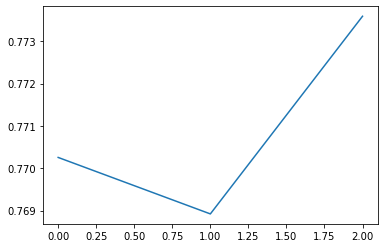

In [39]:
import matplotlib.pyplot as plt
plt.plot(hist.history.get('val_accuracy'))

In [19]:
feature_selection.numericals

['photoamt', 'videoamt', 'fee', 'age']

In [20]:
df_test[feature_selection.numericals].sample(5)

,photoamt,videoamt,fee,age
PetID,,,,
f849d1829,1.0,0,0,3
ef70f3263,4.0,0,0,5
1dcd8bc8a,4.0,0,0,3
972fba985,2.0,0,1,9
11d741736,2.0,0,0,12


In [17]:
encoder = model.encoder
for name in feature_selection.numericals:
    model.encoder.encoding_layers[name] = col.embeddings.layers.PassThroughLayer(name)
    model.encoder.encoding_layers[name].adapt(ds_test)
    

In [18]:
name = 'color2'
model.encoder.predict(ds_test.map(lambda x, y: {name: x[name] for name in feature_selection.numericals}))

array([[-0.8262427 , -0.16302028, -0.26930034,  0.08379945],
       [-0.25766945, -0.16302028, -0.26930034,  2.049002  ],
       [ 0.3109038 , -0.16302028,  0.3774347 , -0.51667905],
       ...,
       [ 0.3109038 , -0.16302028,  4.90458   ,  2.049002  ],
       [-0.25766945, -0.16302028, -0.26930034, -0.51667905],
       [-0.8262427 , -0.16302028, -0.26930034, -0.51667905]],
      dtype=float32)

In [115]:
# encoder = model.encoder
# for col_name in feature_selection.numericals:
#     encoder.encoding_layers[col_name] = col.embeddings.layers.PassThroughLayer(col_name)
    
output = model.encoder.predict(ds_test)


output2 = model.encoder.predict(ds_test)

2022-02-02 21:45:32.552979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [119]:
v = ((output - output2)[5,:])

In [124]:
output = model.encoder.predict(ds_test.map(lambda x,y: x))
output2 = model.encoder.predict(ds_test.map(lambda x,y: x))

In [128]:
t = next(ds_test.take(1).as_numpy_iterator())


In [131]:
output = model.encoder.predict(t[0])
output2 = model.encoder.predict(t[0])

output - output2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [132]:
encoder = col.embeddings.models.TFCatEmbsEncoder(strategy)
encoder.adapt(ds_test)
encoder.set_weights(model.encoder.get_weights())

2022-02-02 21:52:29.787308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 21:52:29.912644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 21:52:30.037731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 21:52:30.157193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 21:52:30.279564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 21:52:30.399974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-02 21:52:30.520977: I tensorflow/core/grappler/optimizers/cust

In [136]:
df[feature_selection.numericals]

In [137]:
encoder.predict(t[0])

2022-02-02 21:53:13.526267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


array([[ 0.03962818, -0.3452057 ,  0.00186167, ..., -0.16189812,
         0.30397525, -0.04112478],
       [-0.03914329, -0.45344108,  0.03778389, ..., -0.16189812,
         0.02671814, -0.04112478],
       [ 0.03962818,  0.08773584,  0.00186167, ..., -0.16189812,
        -0.80505323, -0.04112478],
       ...,
       [ 0.03962818, -0.07461724,  0.02039905, ..., -0.16189812,
        -0.25053898, -0.04112478],
       [ 0.03962818, -0.45344108,  0.00186167, ..., -0.16189812,
        -0.25053898,  0.02086807],
       [-0.03914329, -0.50755876,  0.03778389, ..., -0.16189812,
         0.30397525, -0.04112478]], dtype=float32)

In [57]:
a = model.predict(ds_test)
a.shape, type(a)

((2999, 1), numpy.ndarray)

In [143]:
X = np.random.randn(1000,4)
y = X[:,0] + np.random.randn(1000) / 5

inp = tf.keras.layers.Input(shape=(4,))
x = tf.keras.layers.Dense(2)(inp)
a = tf.keras.models.Model(inp, x)

out = tf.keras.layers.Dense(1)(a(inp))

m = tf.keras.models.Model(inp, out)
m.compile(optimizer='adam', loss='mean_squared_error')
hist = m.fit(X, y, epochs=20, verbose=0, batch_size=5)
m.evaluate(X, y)

2022-02-01 20:01:56.874997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step - loss: 0.0408


2022-02-01 20:02:06.064416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


0.0407966785132885

In [148]:
col.embeddings.TFCatEmbeddingEncoder

[autoreload of columnar.embeddings failed: Traceback (most recent call last):
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/spayot/miniforge3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/spayot/miniforge3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/spayot/projects/mtePlus/notebooks/../src/columnar/embeddings/__init__.py", line 4, in <module>
    from .tf_models import TFCatEmbsModel, TFCatEmbed

AttributeError: module 'columnar.embeddings' has no attribute 'TFCatEmbeddingEncoder'

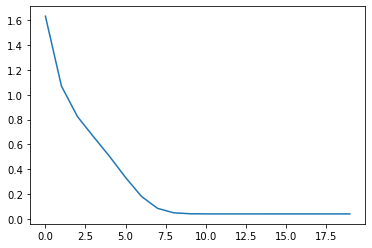

In [144]:
plt.plot(hist.history.get('loss'))

In [147]:
np.matmul(m.get_weights()[0], m.get_weights()[2]).round(2)

array([[ 0.99],
       [-0.01],
       [-0.01],
       [ 0.02]], dtype=float32)

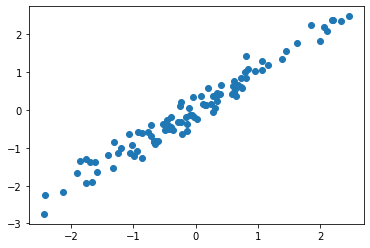

In [130]:
plt.scatter(X[:,0], y)

In [ ]:
loss, acc = model.fit